The ipynb file could be accessed in the github link: https://github.com/leoyuanitis/148-Project

In [1]:
# import necessary package for the project
%pip install scikit-lego
%pip install tensorflow
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression
from sklearn.linear_model import Ridgea
from sklearn import metrics

the laptop_prices dataset is from https://www.kaggle.com/datasets/owm4096/laptop-prices

Since it is a processed dataset, there is no missing value and we don't see a necessity to conduct any intial data clearning. Basic info can be found below such as dimension, variable type, etc.

We try to predict Price_euros (response variable) with other variables available in the dataset. Preliminary analysis is conducted and could be found below. We believe some features would have a impact on the Price_eros based on a real life experiences, such as larger screen / larger storage tends to make price higher.

In [2]:
# load in dataset
df_orig = pd.read_csv('/content/laptop_prices.csv')
df_orig.shape

(1275, 23)

In [3]:
# Set random seed for reproducibility
np.random.seed(148)

# Shuffle the dataframe
df_shuffled = df_orig.sample(frac=1, random_state=148).reset_index(drop=True)

# Calculate the sizes for the splits
train_size = int(0.6 * len(df_shuffled))
val_size = int(0.25 * len(df_shuffled))

# Split the dataframe
df_train = df_shuffled[:train_size]
df_val = df_shuffled[train_size:train_size + val_size]
df_test = df_shuffled[train_size + val_size:]

# Display the sizes of each split
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 765
Validation set size: 318
Test set size: 192


In [4]:
# Implement always predict mean model as the benchmark, compute rooted MSE on train and test set

# Calculate the mean of the target variable in the training set
train_mean = df_train['Price_euros'].mean()

# Predict the mean for all instances in the training and test sets
y_train_pred = [train_mean] * len(df_train)
y_test_pred = [train_mean] * len(df_test)

# Calculate the root mean squared error (RMSE) for the training and test sets
train_rmse = np.sqrt(mean_squared_error(df_train['Price_euros'], y_train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test['Price_euros'], y_test_pred))

# Print the RMSE values
print(train_mean)
print(f"Train rMSE: {train_rmse}")
print(f"Test rMSE: {test_rmse}")
# we get y hat = 1114.98

1114.9815686274508
Train rMSE: 693.2595784354093
Test rMSE: 656.05947776343


In [5]:
# Check-in 2 starts from here (linear regression)
# We select Price_euros as response variable, and Ram as predictor as they have highest correlation
lad_fit = LADRegression() # L1
lad_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('LAD intercept:',lad_fit.intercept_, 'LAD coefficient', lad_fit.coef_[0])

ls_fit = LinearRegression() # L2
ls_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('LS intercept:', ls_fit.intercept_, 'LS coefficient', ls_fit.coef_[0])

LAD intercept: 84.55999999969671 LAD coefficient 115.27750000001757
LS intercept: 287.63527579582444 LS coefficient 99.42191549107667


In [6]:
# plot the Price_euros vs Ram scatter plot and two regression models
fig = px.scatter(df_train, x='Ram', y='Price_euros', title='Price_euros vs Ram')
fig.add_trace(
    go.Scatter(x=df_train['Ram'],
    y=lad_fit.intercept_ + df_train['Ram'] * lad_fit.coef_[0],
    mode='lines', name='LAD Regression')
)

fig.add_trace(
    go.Scatter(x=df_train['Ram'],
    y=ls_fit.intercept_ + df_train['Ram'] * ls_fit.coef_[0],
    mode='lines', name='LS Regression')
)

In [7]:
# Create a  3 column dataframe demontrating real, LAD prediction, LS prediction
pred_val_df = pd.DataFrame(
    {
        'true': df_val['Price_euros'],
        'lad_pred': lad_fit.predict(np.array(df_val['Ram']).reshape(-1, 1)),
        'ls_pred': ls_fit.predict(np.array(df_val['Ram']).reshape(-1, 1))
    }
)
pred_val_df

,true,lad_pred,ls_pred
765,2289.99,1929.00,1878.385924
766,889.00,1006.78,1083.010600
767,3499.00,1929.00,1878.385924
768,1510.00,1006.78,1083.010600
769,797.41,1006.78,1083.010600
...,...,...,...
1078,1399.00,1006.78,1083.010600
1079,699.00,545.67,685.322938
1080,2639.00,3773.44,3469.136572
1081,1686.64,1006.78,1083.010600


In [8]:
# calculate rMSE, MAE, MAD, correlation, R2 of true price with LS & LAD predictions
print('LS rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ls_pred'])))
print('LS MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ls_pred']))
print('LS MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ls_pred'])))
print('LS correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ls_pred'])[0, 1])
print('LS R2:', r2_score(pred_val_df['true'], pred_val_df['ls_pred']))

print('LAD rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['lad_pred'])))
print('LAD MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['lad_pred']))
print('LAD MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['lad_pred'])))
print('LAD correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['lad_pred'])[0, 1])
print('LAD R2:', r2_score(pred_val_df['true'], pred_val_df['lad_pred']))

LS rMSE: 507.5156994969675
LS MAE: 370.6725851745604
LS MAD: 289.16676874228443
LS correlation: 0.7349746051049965
LS R2: 0.530896864818839
LAD rMSE: 513.6157402931136
LAD MAE: 365.3441352201324
LAD MAD: 248.995
LAD correlation: 0.734974605104998
LAD R2: 0.5195524065873021


LS Model: Slightly better in terms of overall fit (higher R², lower rMSE), but has a higher MAE and MAD.

LAD Model: Performs better in minimizing absolute errors (lower MAE and MAD), which makes sense as it L1 loss function penalize less on the absolute deviance.

In general, the errors are high, suggesting the performace for single variable regression model is not ideal. In terms of future improvements, we plan to 1. improve the feature engineering and select more predictors to involve in the linear regression model; 2. try more complex models since there's a chance that the relations for price vs other features aren't best described by linear model.

Based on the figure above, we can't really see any overfitting and underfitting problem. We only use one predictor, the chance of overfit the train set is low. For underfitting problem, both models successfully track the overall uptrend, though errors are relatively high.

In [9]:
# apply ridge regression on the ls_fit model
ridge_fit = Ridge(alpha=1.0)
ridge_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('Ridge intercept:', ridge_fit.intercept_, 'Ridge coefficient:', ridge_fit.coef_[0])

Ridge intercept: 287.6750713949823 Ridge coefficient: 99.41713326780369


Out current regression involves just one feature (Ram), we use Ridge Regression. It regularize the coefficient without driving it to zero (which Lasso might do in some case), thus improving the LS model’s predictive performance by reducing overfitting.

In [10]:
# calculate rMSE, MAE, MAD, correlation, R2 of true price with Ridge predictions
pred_val_df['ridge_pred'] = ridge_fit.predict(np.array(df_val['Ram']).reshape(-1, 1))

print('Ridge rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ridge_pred'])))
print('Ridge MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ridge_pred']))
print('Ridge MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ridge_pred'])))
print('Ridge correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ridge_pred'])[0, 1])
print('Ridge R2:', r2_score(pred_val_df['true'], pred_val_df['ridge_pred']))

Ridge rMSE: 507.5185650419886
Ridge MAE: 370.67442316655104
Ridge MAD: 289.17787100180453
Ridge correlation: 0.7349746051049979
Ridge R2: 0.5308915674853786


The metrics suggest that Ridge didn't offer a better performance vs least_squre model. The particuar reason is that we only invole one predictor in the model, and there isn't overfitting concern. Hence, regularize the model with Ridge won't significantly improve our model. We tried to tune the alpha value, but they all generate similar rMSE, MAE, etc.

In [11]:
# train multi-predictor ls model on Ram ScreenH ScreenW CPU_freq SecondaryStorage to predict Price_euros,
# predictors are selected based on correlation with the response variable
ls_fit2 = LinearRegression() # L2
ls_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])
print('LS intercept:', ls_fit.intercept_, 'LS coefficient', ls_fit2.coef_)

LS intercept: 287.63527579582444 LS coefficient [ 7.50605502e+01  1.24123651e+00 -3.39109718e-01  2.64790768e+02
  3.63551711e-02]


In [12]:
# Predict using the multi-variable model
pred_val_df['ls_fit2_pred'] = ls_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])

# Calculate and print the metrics for the multi-variable model
print('LS_fit2 rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ls_fit2_pred'])))
print('LS_fit2 MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ls_fit2_pred']))
print('LS_fit2 MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ls_fit2_pred'])))
print('LS_fit2 correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ls_fit2_pred'])[0, 1])
print('LS_fit2 R2:', r2_score(pred_val_df['true'], pred_val_df['ls_fit2_pred']))

LS_fit2 rMSE: 443.45226720702334
LS_fit2 MAE: 322.52749367335633
LS_fit2 MAD: 242.6219121732812
LS_fit2 correlation: 0.8048758390097857
LS_fit2 R2: 0.6418515035952008


In [13]:
# Apply Ridge regression on ls_fit2
ridge_fit2 = Ridge(alpha=1.0)
ridge_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

print('Ridge intercept:', ridge_fit2.intercept_)
print('Ridge coefficients:', ridge_fit2.coef_)

# Predict using the Ridge model
pred_val_df['ridge_fit2_pred'] = ridge_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])

# Calculate and print the metrics for the Ridge model
print('Ridge_fit2 rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ridge_fit2_pred'])))
print('Ridge_fit2 MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ridge_fit2_pred']))
print('Ridge_fit2 MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ridge_fit2_pred'])))
print('Ridge_fit2 correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ridge_fit2_pred'])[0, 1])
print('Ridge_fit2 R2:', r2_score(pred_val_df['true'], pred_val_df['ridge_fit2_pred']))

Ridge intercept: -810.0083691065381
Ridge coefficients: [ 7.51011269e+01  1.23890275e+00 -3.37667853e-01  2.63257804e+02
  3.65148054e-02]
Ridge_fit2 rMSE: 443.47546292412096
Ridge_fit2 MAE: 322.5350147213434
Ridge_fit2 MAD: 242.90029581710803
Ridge_fit2 correlation: 0.8048685129346614
Ridge_fit2 R2: 0.641814035172613


In [14]:
# Define the range of alpha values to test
alpha_values = [0.01, 0.1, 1, 10, 100]

best_alpha = None
best_rmse = float('inf')
best_coef = None

for alpha in alpha_values:
    ridge_fit2 = Ridge(alpha=alpha)
    ridge_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

    pred_val = ridge_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])
    rmse = np.sqrt(mean_squared_error(df_val['Price_euros'], pred_val))

    print(f"Alpha: {alpha}, RMSE: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_coef = ridge_fit2.coef_

print(f"\nBest alpha: {best_alpha}, Best RMSE: {best_rmse}")
print(f"Best coefficients: {best_coef}")

# Evaluate the model with the best alpha on the test set
ridge_fit2_best = Ridge(alpha=best_alpha)
ridge_fit2_best.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

pred_test = ridge_fit2_best.predict(df_test[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])
rmse_test = np.sqrt(mean_squared_error(df_test['Price_euros'], pred_test))

print(f"\nTest set performance with best alpha ({best_alpha}):")
print(f"RMSE: {rmse_test}")

Alpha: 0.01, RMSE: 443.4524951770976
Alpha: 0.1, RMSE: 443.4545505768866
Alpha: 1, RMSE: 443.47546292412096
Alpha: 10, RMSE: 443.7159490756136
Alpha: 100, RMSE: 447.0534413877157

Best alpha: 0.01, Best RMSE: 443.4524951770976
Best coefficients: [ 7.50609587e+01  1.24121303e+00 -3.39095217e-01  2.64775349e+02
  3.63567753e-02]

Test set performance with best alpha (0.01):
RMSE: 421.8292163699837


In [15]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data Preprocessing
scaler = StandardScaler()

# Standardize the features
X_train_scaled = scaler.fit_transform(df_train[['ScreenW', 'ScreenH', 'Ram']].values)
X_val_scaled = scaler.transform(df_val[['ScreenW', 'ScreenH', 'Ram']].values)

# Define the target variable
y_train = df_train['Price_euros'].values
y_val = df_val['Price_euros'].values

# Ensure the target variable is a NumPy array
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(1)  # Linear activation for regression
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

# Convert all inputs to NumPy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_val_scaled = np.array(X_val_scaled)
y_val = np.array(y_val)

# Check for NaN or invalid values and handle them
X_train_scaled = np.nan_to_num(X_train_scaled)
y_train = np.nan_to_num(y_train)
X_val_scaled = np.nan_to_num(X_val_scaled)
y_val = np.nan_to_num(y_val)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=20, batch_size=32, verbose=2)


# Evaluate the model
loss, mse = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}, Validation MSE: {mse:.4f}")

# Predictions and Metrics
y_val_pred = model.predict(X_val_scaled)

# Calculate metrics
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
24/24 - 6s - 251ms/step - loss: 1723139.6250 - mse: 1723138.3750 - val_loss: 1930646.1250 - val_mse: 1930644.8750
Epoch 2/20
24/24 - 0s - 10ms/step - loss: 1717782.3750 - mse: 1717781.2500 - val_loss: 1919534.7500 - val_mse: 1919533.2500
Epoch 3/20
24/24 - 0s - 13ms/step - loss: 1694830.3750 - mse: 1694828.6250 - val_loss: 1872719.2500 - val_mse: 1872717.8750
Epoch 4/20
24/24 - 0s - 12ms/step - loss: 1607410.2500 - mse: 1607408.5000 - val_loss: 1713056.2500 - val_mse: 1713054.0000
Epoch 5/20
24/24 - 0s - 15ms/step - loss: 1382180.1250 - mse: 1382177.7500 - val_loss: 1349055.3750 - val_mse: 1349052.3750
Epoch 6/20
24/24 - 0s - 7ms/step - loss: 975273.8125 - mse: 975270.3125 - val_loss: 837469.2500 - val_mse: 837465.3750
Epoch 7/20
24/24 - 0s - 15ms/step - loss: 591609.4375 - mse: 591605.1250 - val_loss: 494628.8438 - val_mse: 494624.0938
Epoch 8/20
24/24 - 0s - 10ms/step - loss: 432479.5938 - mse: 432474.4688 - val_loss: 378145.7500 - val_mse: 378140.6562
Epoch 9/20
24/24 - 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Epoch 1/20
24/24 - 0s - 18ms/step - loss: 220804.7656 - mse: 220799.3750 - val_loss: 214121.0781 - val_mse: 214115.6719 - learning_rate: 0.0011
Epoch 2/20
24/24 - 0s - 12ms/step - loss: 227577.6562 - mse: 227572.2188 - val_loss: 210983.3906 - val_mse: 210977.9375 - learning_rate: 0.0012
Epoch 3/20
24/24 - 0s - 10ms/step - loss: 223957.7500 - mse: 223952.3750 - val_loss: 223632.0312 - val_mse: 223626.7188 - learning_rate: 0.0013
Epoch 4/20
24/24 - 0s - 13ms/step - loss: 220881.2969 - mse: 220875.9688 - val_loss: 215415.3438 - val_mse: 215409.9375 - learning_rate: 0.0015
Epoch 5/20
24/24 - 0s - 11ms/step - loss: 210628.8906 - mse: 210623.4375 - val_loss: 219070.4375 - val_mse: 219065.0781 - learning_rate: 0.0016
Epoch 6/20
24/24 - 0s - 18ms/step - loss: 218373.8750 - mse: 218368.5000 - val_loss: 210180.4688 - val_mse: 210175.0000 - learning_rate: 0.0018
Epoch 7/20
24/24 - 1s - 32ms/step - loss: 211296.7812 - mse: 211291.3125 - val_loss: 225705.6094 - val_mse: 225700.2812 - learning_rate:

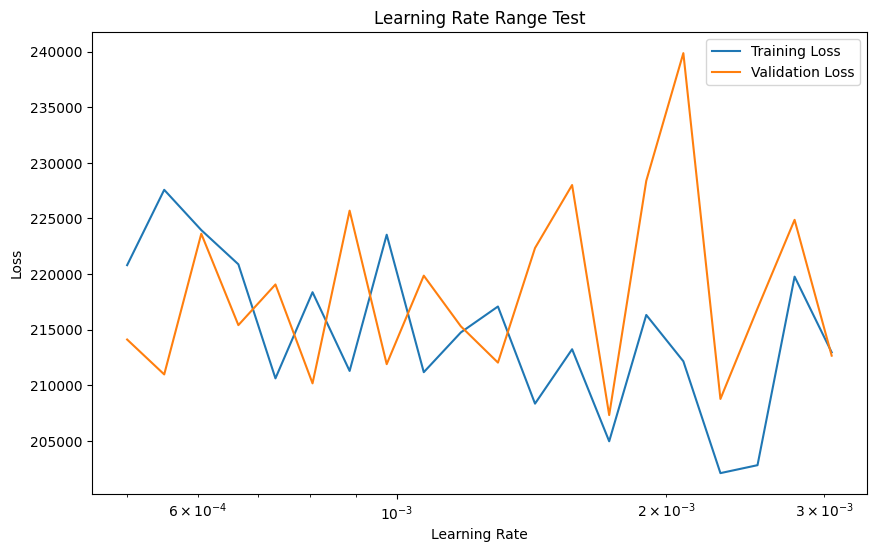

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Define a learning rate range test
def lr_schedule(epoch, lr):
    return lr * 1.1  # Increase learning rate by 10% every epoch

# Callback to schedule learning rate
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with the learning rate scheduler
history_lr_test = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,  # Use a few epochs to test learning rates
    batch_size=32,
    verbose=2,
    callbacks=[lr_scheduler]
)

# Plot the learning rate vs. loss
lrs = [0.0005 * (1.1 ** i) for i in range(len(history_lr_test.history['loss']))]
plt.figure(figsize=(10, 6))
plt.plot(lrs, history_lr_test.history['loss'], label='Training Loss')
plt.plot(lrs, history_lr_test.history['val_loss'], label='Validation Loss')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.legend()
plt.show()

We tried different learning rate and found that when learning rate = 0.001, this graph looks the best.

We evaluated the model using MSE, RMSE, MAE, and R².

MAE of 343.11 euros indicates the average magnitude of prediction error.
An RMSE of 494.27 means that, on average, the model's predictions deviate by 494 euros from the actual prices.

The R² of 0.6058 suggests that the model explains 60.6% of the variance in Price_euros.

Appendix:
EDA, data preprocessing, logistic regression analysis, random forest, PCA implementations are submitted in previous project check-in's.